In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
Station = Base.classes.station
Measurement = Base.classes.measurement

C:\Users\liana\AppData\Local\Temp\ipykernel_18188\1124118679.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
for table_name in Base.classes.keys():
    print(table_name)
    

measurement
station


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


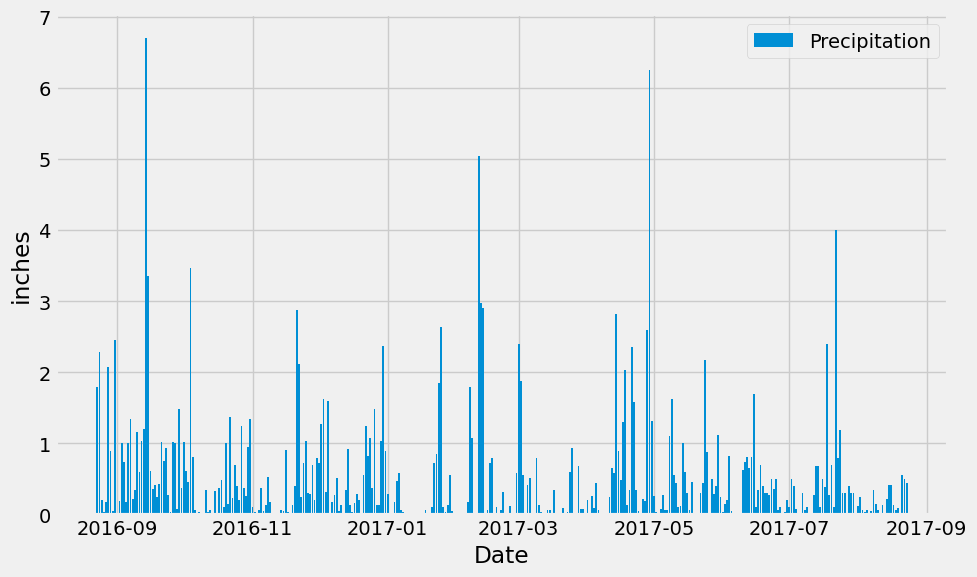

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = (pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')


# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago)\
    .order_by(Measurement.date)\
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')


# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(df['date'], df['precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('inches')
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df.describe()
print(summary_stats)

                                date  precipitation
count                           2230    2021.000000
mean   2017-02-16 05:31:15.874439424       0.177279
min              2016-08-23 00:00:00       0.000000
25%              2016-11-18 00:00:00       0.000000
50%              2017-02-14 12:00:00       0.020000
75%              2017-05-17 00:00:00       0.130000
max              2017-08-23 00:00:00       6.700000
std                              NaN       0.461190


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(total_stations)

9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('station_count'))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()
for station, count in active_stations:
    print(station, count)



USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations[0][0]
temperature_stats = session.query(func.min(Measurement.tobs).label('min_temp'),
                                  func.max(Measurement.tobs).label('max_temp'),
                                  func.avg(Measurement.tobs).label('avg_temp'))\
    .filter(Measurement.station == most_active_station_id)\
    .first()
print(temperature_stats)

(54.0, 85.0, 71.66378066378067)


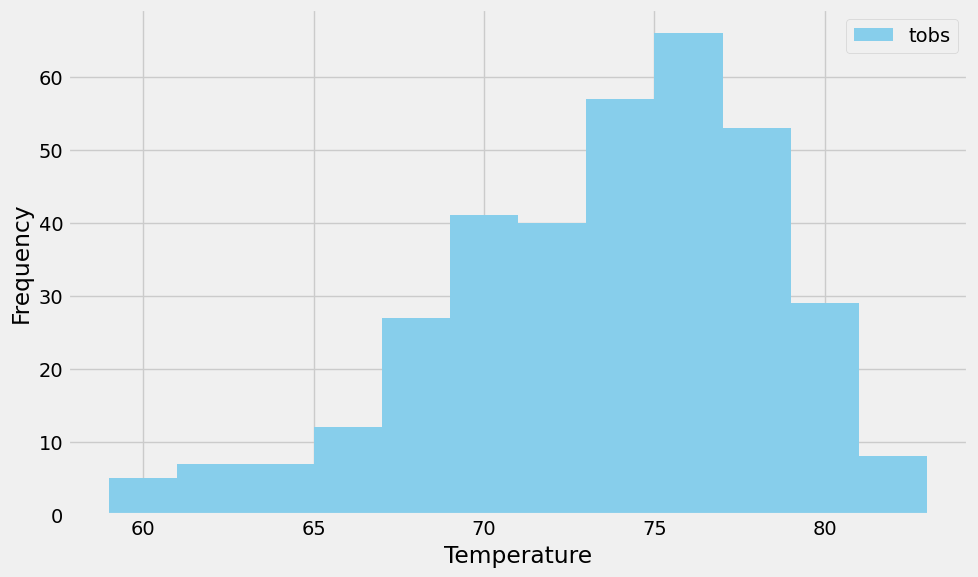

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station_id, Measurement.date >= one_year_ago)\
    .all()
df_tobs = pd.DataFrame(tobs_data, columns=['temperature'])
plt.figure(figsize=(10, 6))
plt.hist(df_tobs['temperature'], bins=12, label='tobs', color='skyblue')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [ ]:
# Close Session
session.close()